In [191]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler     # 평균 0, 표준편차 1로 데이터 스케일링 도구
from sklearn.model_selection import train_test_split # 학습/(검증)/테스트 데이터 분할

import torch                     # Tensor 연산 및 핵심 기능
import torch.nn as nn            # 신경망 레이어 구성 및 모델 구성 모듈
import torch.nn.functional as F  # 활성화함수/손실함수 등 함수
import torch.optim as optim      # 옵티마이저(최적화 알고리즘)

In [192]:
df = pd.read_csv('./data/fetch_california_housing.csv')
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [193]:
# X, y 데이터를 분리
X = df.drop(columns="MedHouseVal")

print(X.shape)

(20640, 8)


In [194]:
y = df['MedHouseVal']
print(y.shape)

(20640,)


In [195]:
# Train / Test 데이터셋 분리  (train_test_split 옵션 X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,             # 전세 입력데이터와 타겟데이터
    test_size =0.2,    # 테스트 데이터셋의 비율
    random_state = 42 # 난수시드
)

print(f"X_train : {len(X_train)}")
print(f"X_test : {len(X_test)}")
print(f"y_train : {len(y_train)}")
print(f"y_test : {len(y_test)}")

X_train : 16512
X_test : 4128
y_train : 16512
y_test : 4128


In [196]:
X_scaler = StandardScaler()     # 스케일링 객체 생성

X_train_scaled = X_scaler.fit_transform(X_train) # train 데이터로 평균0, 표준편차 1 학습 및 변환
X_test_scaled = X_scaler.transform(X_test)       # train 데이터를 기준으로 test 데이터를 변환

In [197]:
# 데이터 프레임 형태로 다시 만들어주기-> X_train_scaled가 array형태이기 때문에~
X_train_scaled = pd.DataFrame(
    X_train_scaled,             # 스케일링된 데이터 (narray -> dataframe)
    columns = X_train.columns, # 기존 컬럼명 유지
    index = X_train.index       # 기존 인덱스 유지
)

X_test_scaled = pd.DataFrame(
    X_test_scaled,             # 스케일링된 데이터 (narray -> dataframe)
    columns = X_test.columns, # 기존 컬럼명 유지
    index = X_test.index       # 기존 인덱스 유지
)

In [198]:
y_train.values

array([1.03 , 3.821, 1.726, ..., 2.221, 2.835, 3.25 ], shape=(16512,))

## view(-1, 1)을 사용하는 이유
### Linear 레이어가 2차원 출력으로 나온다 (N, out_features) -> y_hat(예측값), y의 형태를 맞춰준다.   
### 이걸 맞춰주지 않으면 y_train은 (16512,) 1차원 y_hawt(16512, 1)이걸 가지고 loss계산을 할 때 loss값이 생각과 다르게 나온다.

In [199]:
# 데이터프레임을 Pytorch 텐서로 변환해서 모델 학습 준비

X_train_tensor = torch.from_numpy(X_train_scaled.to_numpy()).float() # train 입력 데이터를 Pytorch Tensor(float)로 변환
# X_train_tensor = torch.FloatTensor(X_train_scaled.to_numpy()와 같음) 
X_test_tensor = torch.from_numpy(X_test_scaled.to_numpy()).float()   # test 입력 데이터를 Pytorch Tensor(float)로 변환


y_train_tensor = torch.from_numpy(y_train.values).float().view(-1, 1)  # 타겟 데이터는 (샘플 수, 1) 형태로 변환
y_test_tensor = torch.from_numpy(y_test.values).float().view(-1, 1)     # 출력 차원을 맞춰주기 위한 reshape

print(X_train_tensor.size(), X_test_tensor.size(), y_train_tensor.size(), y_test_tensor.size())

torch.Size([16512, 8]) torch.Size([4128, 8]) torch.Size([16512, 1]) torch.Size([4128, 1])


In [200]:
# 하이퍼파라미터 설정
n_epochs = 7000       # 학습반복횟수
learning_rate = 1e-3  # 학습률 (0.001)
print_interval = 1000  # 학습 손실 출력 주기

모델 (nn.Sequential)을 사용해서 3개의 은닉층과 ReLU 활성화를 갖는 심층 회귀 모델   
- 입력(X_train_tensor.size(-1), 64) 은닉 -> (64, 64)은닉 -> (64, 32)은닉 -> 출력(32, y_train_tensor.size(-1))
- 은닉층의 활성화 함수는 ReLU

In [201]:
y_train_tensor.size()

torch.Size([16512, 1])

In [202]:
model = nn.Sequential(
    # 입력 -> 은닉
    nn.Linear(X_train_tensor.size(-1), 256),   # 입력 특성 수 8 -> 은닉 노드 64개
    nn.BatchNorm1d(256),
    nn.ReLU(),                                # 비선형성 추가
    nn.Dropout(0.2),     # [추가] 과대적합 방지 (20% 끄기)

    # 두번째 은닉층
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.2),

    # 3층: 64 -> 32 (층 하나 추가)
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Dropout(0.2),

    # 출력층
    nn.Linear(64, y_train_tensor.size(-1))   # 최종 출력 차원으로 변환 (회귀 : 1) //다중출력이면 해당 특성수//
)

In [203]:
# Optimizer 설정
optimizer = optim.RAdam(  # Adam: 모멘텀 + RMSProp을 결합한 최적화 알고리즘
    model.parameters(),  # 학습 대상이 되는 모든 가중치, 편향 파라미터
    lr = learning_rate,  # 학습률
    weight_decay=1e-4  # [핵심] 가중치 규제 추가
)

In [204]:
# torch.cuda.is_available()

In [205]:
# 학습에 들어가기 전 설정
# 디바이스 설정
device = torch.device("mps" if torch.mps.is_available() else "cpu")
model = model.to(device)

X_train = X_train_tensor.to(device)
y_train = y_train_tensor.to(device)
X_test = X_test_tensor.to(device)
y_test = y_test_tensor.to(device)

### model.train() -> 학습모드
- 무조건 써야하는 상황
    - 딥러닝 모델 안에서 Dropout(), BatchNorm() 사용할 시
    - 과적합 장지용으로 거의 들어간다.

In [206]:
# 학습 루프
for epoch in range(n_epochs):
    model.train()            # 학습 모드(딥러닝 모델안에)

    y_hat = model(X_train)   # 순전파
    loss = F.mse_loss(y_hat, y_train)  # 평균제곱오차 손실 계산

    optimizer.zero_grad()    # 이전 step의 기울기 초기화
    loss.backward()          # 역전파 : 손실을 기준으로 gradient 계산
    optimizer.step()         # 파라미터 업데이트

    # 500번마다 학습손실 출력
    if (epoch + 1) % print_interval == 0:
        print(f'Epoch : {epoch + 1}의 train_loss: {loss.item():.4e}')

# 학습이 끝난 후 테스트 손실 출력 (선택)
model.eval()            # 평가 모드 설정 (Dropout, batchnorm 비활성화)

with torch.no_grad():            # 이 안에서는 기울기 계산 비활성화
    y_pred_test = model(X_test)  # 테스트 데이터로 예측
    test_loss = F.mse_loss(y_pred_test, y_test)  # 테스트 손실 계산

print(f"Test_MSE: {test_loss.item():.3e}")


Epoch : 1000의 train_loss: 3.5118e-01
Epoch : 2000의 train_loss: 2.9218e-01
Epoch : 3000의 train_loss: 2.5173e-01
Epoch : 4000의 train_loss: 2.2264e-01
Epoch : 5000의 train_loss: 1.9529e-01
Epoch : 6000의 train_loss: 1.7280e-01
Epoch : 7000의 train_loss: 1.5769e-01
Test_MSE: 2.264e-01


In [207]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test).cpu().numpy().reshape(-1)   # 예측값을 CPU -> Numpy변환 -> 1차원 배열로 형태 변환
    y_true = y_test.cpu().numpy().reshape(-1)          # 실제값을 CPU -> Numpy변환 -> 1차원 배열로 형태 변환

df_result = pd.DataFrame(
    {
        "y": y_true,
        "y_hat": y_pred
    }
)

df_result

,y,y_hat
0,0.47700,0.565888
1,0.45800,0.972575
2,5.00001,4.890836
3,2.18600,2.350972
4,2.78000,2.565098
...,...,...
4123,2.63300,2.443190
4124,2.66800,2.580816
4125,5.00001,4.577607
4126,0.72300,0.700065


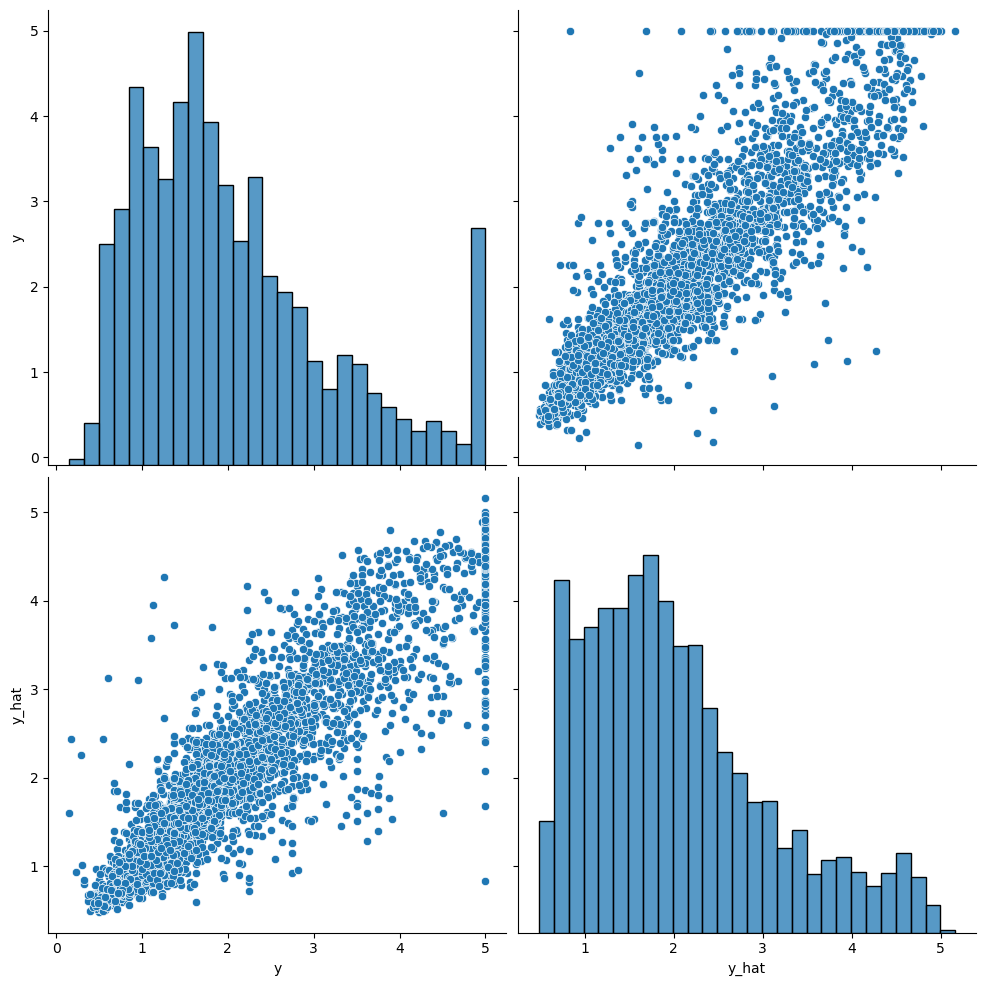

In [208]:
sns.pairplot(df_result, height=5)
plt.show()

### 성능을 끌어올려보자 (현재 Test MSE: 2.1798e+01)   
- 은닉층을 줄이거나 늘려본다. (예: 64 -> 32 -> 16 or 200 -> 150 -> 100 -> 50)
- (과적합시에는) Dropout or batchNorm같은것도 딥러닝 모델 안에 넣어본다.
- lr별로도 비교해보기
- Epoch수를 늘려본다. (과적합 방지를 위해 early stopping도 넣어본다.)
- 데이터가 많지 않으므로 머신러닝 모델도 한번 넣어본다.